# Importing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow

In [ ]:
# Import libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.impute import SimpleImputer

In [ ]:
#  get a list of yml files
dir_path = os.path.join("/content/drive/My Drive/", "UBS_Challenge")
df_dir_path = os.path.join("/content/drive/My Drive/", "UBS_Challenge", "df_save")
weight_dir_path = os.path.join(dir_path, "weight_files")

In [ ]:
# Load the DataFrame from the pickle file
loaded_df = pd.read_pickle(os.path.join(df_dir_path, "dummyTrade1_Expiry_3y_Tenor_3y.pkl"))

# Display the loaded DataFrame
loaded_df

,index,Date,Expiry,Tenor,Swap Rate,atm-1.0%,atm-0.5%,atm,atm+0.5%,atm+1.0%,...,Vega shock -25,Vega shock -10,Vega shock -5,Vega shock 0,Vega shock 5,Vega shock 10,Vega shock 25,Vega shock 50,Vega shock 75,Vega shock 100
0,0,2021-01-13,3y,3y,0.926464,0.126845,0.097976,0.064286,0.101715,0.138284,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2021-01-15,3y,3y,0.909138,0.126421,0.098006,0.063943,0.101482,0.138040,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2021-01-18,3y,3y,0.911595,0.126314,0.097693,0.063760,0.101355,0.137900,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2021-01-19,3y,3y,0.897848,0.125957,0.095190,0.063558,0.101041,0.137519,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2021-01-20,3y,3y,0.906676,0.126691,0.092632,0.064357,0.101635,0.138296,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,749,2024-01-08,3y,3y,3.110386,1.062981,1.065748,1.078728,1.101962,1.134488,...,13.054805,7.837098,11.382627,-10.217085,3.250830,-1.691202,-10.995377,2.988663,-1.774008,3.453038
750,750,2024-01-09,3y,3y,3.118041,1.053326,1.056185,1.069095,1.092077,1.124198,...,14.845626,12.220682,8.190720,3.654435,0.465170,-8.901062,1.681433,5.394763,0.341371,2.448011
751,751,2024-01-10,3y,3y,3.124089,1.078360,1.082165,1.095708,1.118975,1.151090,...,17.525630,0.038723,5.626285,-1.941919,1.514918,-6.057274,5.861185,5.004043,5.190675,4.022827
752,752,2024-01-11,3y,3y,3.080200,1.087504,1.092564,1.106701,1.129842,1.161218,...,8.916819,22.398760,21.049154,10.951858,4.202208,2.800921,-0.382249,-8.216384,7.142869,8.110645


# Data Pre-processing

In [ ]:
n_clusters = 3 # Select n_clusters here

# Load the DataFrame from the pickle file
loaded_df = pd.read_pickle(os.path.join(df_dir_path, "dummyTrade1_Expiry_3y_Tenor_3y.pkl"))

loaded_df = loaded_df[['Date', 'Swap Rate', 'atm', 'Vega shock 0']]

# Rename the 'Vega shock 0' column
loaded_df.rename(columns={'atm': 'Implied Normal Volatility', 'Vega shock 0': 'Vega'}, inplace=True)

# Identify the first non-NaN index and count non-NaN values
first_non_nan_index = loaded_df['Vega'].first_valid_index()
non_nan_count = loaded_df['Vega'].count()

# Print the first non-NaN index and associated date
first_non_nan_date = loaded_df.loc[first_non_nan_index, 'Date']
print(f"First non-NaN index: {first_non_nan_index}, Date: {first_non_nan_date}")
print(f"Number of non-NaN values: {non_nan_count}")

# Identify the last NaN value's index
last_nan_index = loaded_df['Vega'][loaded_df['Vega'].isna()].index[-1]

# Print the last NaN index and associated date
last_nan_date = loaded_df.loc[last_nan_index, 'Date']
print(f"Last NaN index: {last_nan_index}, Date: {last_nan_date}")
print(f"First non-NaN index: {first_non_nan_index}")
print(f"Number of non-NaN values: {non_nan_count}")

print("\n\n=============\n\n")

# Function to compute moving averages and perform clustering
def compute_moving_average_and_clustering(df, column, window, shift_value, prefix):
    # Custom rolling mean function to handle partial windows
    df[f'{prefix}'] = df[column].rolling(window=window, min_periods=1).mean().shift(shift_value)

    # Extract non-NaN moving averages
    non_nan_moving_averages = df[f'{prefix}'].dropna().values.reshape(-1, 1)

    # Perform clustering with 4 clusters
    kmeans = KMeans(n_clusters=n_clusters, n_init=10)
    cluster_labels = kmeans.fit_predict(non_nan_moving_averages)

    # Analyze the distribution of each cluster
    df[f'{prefix} Cluster'] = np.nan
    df.loc[df[f'{prefix}'].notna(), f'{prefix} Cluster'] = cluster_labels + 1

    # Calculate the medians of each cluster
    cluster_medians = df.loc[df[f'{prefix} Cluster'].notna(), [f'{prefix}', f'{prefix} Cluster']].groupby(f'{prefix} Cluster').median().abs()

    # Sort clusters by the absolute value of the median
    sorted_clusters = cluster_medians[f'{prefix}'].sort_values().index.tolist()

    # Remap cluster labels based on sorted order
    cluster_mapping = {old: new for new, old in enumerate(sorted_clusters, start=1)}
    df[f'{prefix} Cluster'] = df[f'{prefix} Cluster'].map(cluster_mapping)

    df[f'{prefix} Cluster'] = df[f'{prefix} Cluster'].astype('Int64')  # Convert to integer with NaN support

    for i in range(1, n_clusters + 1):
        cluster_data = df[df[f'{prefix} Cluster'] == i][f'{prefix}']
        print(f"Cluster {i} for {prefix}:")
        print(f"Min: {cluster_data.min()}")
        print(f"25th Percentile: {cluster_data.quantile(0.25)}")
        print(f"Median: {cluster_data.median()}")
        print(f"75th Percentile: {cluster_data.quantile(0.75)}")
        print(f"Max: {cluster_data.max()}")
        print("\n")

    # Categorize moving averages into clusters and create one-hot encoded columns
    def one_hot_encode_cluster(x, cluster_num):
        if pd.isna(x):
            return np.nan
        return 1 if x == cluster_num else 0

    # for i in range(1, n_clusters + 1):
    #     df[f'{prefix} Cluster {i}'] = df[f'{prefix} Cluster'].apply(lambda x: one_hot_encode_cluster(x, i)).astype('Int64')

    # # Ensure that cluster columns are NaN if the moving average is NaN
    # for i in range(1, n_clusters + 1):
    #     df[f'{prefix} Cluster {i}'] = df.apply(lambda row: np.nan if pd.isna(row[f'{prefix}']) else row[f'{prefix} Cluster {i}'], axis=1).astype('Int64')

# Define the windows
windows = {
    't+1 to t+5': (-1, -5)
}

# Apply the function to each window
for label, (start, end) in windows.items():
    compute_moving_average_and_clustering(loaded_df, 'Vega', start - end + 1, end, f'Vega MA {label}')

# Ensure that all columns are displayed
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Display the resulting DataFrame
loaded_df.tail(400)

First non-NaN index: 410, Date: 2022-09-02
Number of non-NaN values: 336
Last NaN index: 495, Date: 2023-01-02
First non-NaN index: 410
Number of non-NaN values: 336




Cluster 1 for Vega MA t+1 to t+5:
Min: -11.563781062
25th Percentile: 0.1880825399999986
Median: 2.83159744
75th Percentile: 8.816687646
Max: 16.554838044


Cluster 2 for Vega MA t+1 to t+5:
Min: 16.698747802
25th Percentile: 22.341648188
Median: 26.757079111
75th Percentile: 36.315728887
Max: 47.491319074


Cluster 3 for Vega MA t+1 to t+5:
Min: -11505.349523308
25th Percentile: -11502.908120558
Median: -11502.877896294
75th Percentile: -11502.149707084
Max: -11500.288522768




,Date,Swap Rate,Implied Normal Volatility,Vega,Vega MA t+1 to t+5,Vega MA t+1 to t+5 Cluster
354,2022-06-14,2.945934,0.072497,NaN,NaN,<NA>
355,2022-06-15,2.859921,0.072817,NaN,NaN,<NA>
356,2022-06-16,2.719031,0.070476,NaN,NaN,<NA>
357,2022-06-17,2.682615,0.069588,NaN,NaN,<NA>
358,2022-06-20,2.619587,0.067884,NaN,NaN,<NA>
359,2022-06-21,2.765887,0.068706,NaN,NaN,<NA>
360,2022-06-22,2.654932,0.067491,NaN,NaN,<NA>
361,2022-06-23,2.555744,0.067024,NaN,NaN,<NA>
362,2022-06-24,2.626183,0.068052,NaN,NaN,<NA>
363,2022-06-27,2.684751,0.067528,NaN,NaN,<NA>


# LSTM - Classification - n_steps = 60

In [ ]:
# Prepare the data
df = loaded_df
n_features = 3  # 'Swap Rate', 'Implied Normal Volatility', 'Vega'
n_steps = 60

# Hyperparameters
epochs=150
batch_size=32

# Impute NaN values with the mean of the column
imputer = SimpleImputer(strategy='mean')
df[['Swap Rate', 'Implied Normal Volatility', 'Vega']] = imputer.fit_transform(df[['Swap Rate', 'Implied Normal Volatility', 'Vega']])

# Standardize the features
scaler = StandardScaler()
features = scaler.fit_transform(df[['Swap Rate', 'Implied Normal Volatility', 'Vega']])

# Function to create sequences
def create_sequences(features, target, n_steps):
    X, y = [], []
    for i in range(n_steps, len(features)):
        X.append(features[i-n_steps:i, :])
        y.append(target[i])
    return np.array(X), np.array(y)

# Create sequences for the entire dataset
X, y = create_sequences(features, df['Vega MA t+1 to t+5 Cluster'].values.astype(float), n_steps)

# Filter out sequences where the target value is NaN
valid_indices = ~pd.isna(y)
X = X[valid_indices]
y = y[valid_indices].astype(int)  # Ensure y is integer type

# Adjust y to be 0, 1, 2 for the model training
y_adjusted = y - 1

# Convert targets to categorical
y_categorical = pd.get_dummies(y_adjusted).values

# Split the data into training and testing
X_train, X_test = X[:-60], X[-60:]
y_train, y_test = y_categorical[:-60], y_categorical[-60:]

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define checkpoint to save the best model
checkpoint_filepath = os.path.join(weight_dir_path, 'best_lstm_classification_model_n_steps_60.h5')
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_accuracy', mode='max')

# Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[checkpoint])

# Save the final model weights
model.save_weights(os.path.join(weight_dir_path, 'lstm_classification_final_weights_n_steps_60.h5'))

# Print the training and testing loss and accuracy
training_loss = history.history['loss']
testing_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
testing_accuracy = history.history['val_accuracy']

print("Training Loss:", training_loss)
print("Testing Loss:", testing_loss)
print("Training Accuracy:", training_accuracy)
print("Testing Accuracy:", testing_accuracy)

Epoch 1/150
9/9 [==============================] - ETA: 0s - loss: 1.0296 - accuracy: 0.5951

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 7s 315ms/step - loss: 1.0296 - accuracy: 0.5951 - val_loss: 1.2149 - val_accuracy: 0.0500
Epoch 2/150
9/9 [==============================] - 1s 119ms/step - loss: 0.9288 - accuracy: 0.8838 - val_loss: 1.7825 - val_accuracy: 0.0500
Epoch 3/150
9/9 [==============================] - 1s 110ms/step - loss: 0.7496 - accuracy: 0.8908 - val_loss: 1.5124 - val_accuracy: 0.0500
Epoch 4/150
9/9 [==============================] - 1s 119ms/step - loss: 0.7513 - accuracy: 0.8873 - val_loss: 2.0572 - val_accuracy: 0.0500
Epoch 5/150
9/9 [==============================] - 1s 135ms/step - loss: 0.6838 - accuracy: 0.8838 - val_loss: 1.7515 - val_accuracy: 0.4833
Epoch 6/150
9/9 [==============================] - 1s 104ms/step - loss: 1.0527 - accuracy: 0.8697 - val_loss: 2.4118 - val_accuracy: 0.0500
Epoch 7/150
9/9 [==============================] - 1s 101ms/step - loss: 0.6928 - accuracy: 0.8908 - val_loss: 2.2036 - val_accuracy: 0.0500
Epoch 8/150
9/9 [========

2/2 [==============================] - 1s 25ms/step


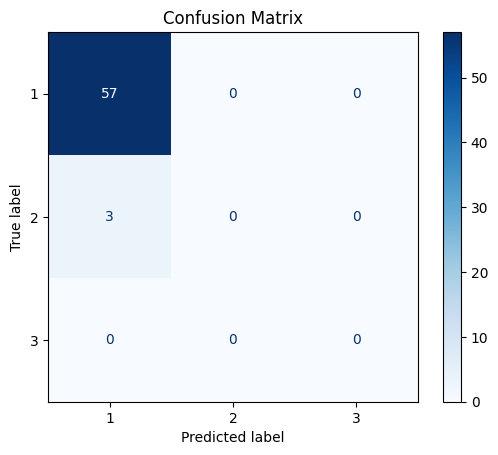

In [ ]:
# Prepare the data
df = loaded_df
n_features = 3  # 'Swap Rate', 'Implied Normal Volatility', 'Vega'
n_steps = 60

# Impute NaN values with the mean of the column
imputer = SimpleImputer(strategy='mean')
df[['Swap Rate', 'Implied Normal Volatility', 'Vega']] = imputer.fit_transform(df[['Swap Rate', 'Implied Normal Volatility', 'Vega']])

# Standardize the features
scaler = StandardScaler()
features = scaler.fit_transform(df[['Swap Rate', 'Implied Normal Volatility', 'Vega']])

# Function to create sequences
def create_sequences(features, target, n_steps):
    X, y = [], []
    for i in range(n_steps, len(features)):
        X.append(features[i-n_steps:i, :])
        y.append(target[i])
    return np.array(X), np.array(y)

# Create sequences for the entire dataset
X, y = create_sequences(features, df['Vega MA t+1 to t+5 Cluster'].values.astype(float), n_steps)

# Filter out sequences where the target value is NaN
valid_indices = ~pd.isna(y)
X = X[valid_indices]
y = y[valid_indices].astype(int)  # Ensure y is integer type

# Adjust y to be 0, 1, 2 for the model training
y_adjusted = y - 1

# Convert targets to categorical
y_categorical = pd.get_dummies(y_adjusted).values

# Split the data into training and testing
X_train, X_test = X[:-60], X[-60:]
y_train, y_test = y_categorical[:-60], y_categorical[-60:]

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Load the model weights
model.load_weights(os.path.join(weight_dir_path, 'best_lstm_classification_model_n_steps_60.h5'))

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Adjust the classes back to 1, 2, 3
y_pred_classes_adjusted = y_pred_classes + 1
y_test_classes_adjusted = y_test_classes + 1

# Compute and display the confusion matrix
cm = confusion_matrix(y_test_classes_adjusted, y_pred_classes_adjusted, labels=[1, 2, 3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# LSTM - Prediction - n_steps = 60

In [ ]:
# Prepare the data
df = loaded_df
n_features = 3  # 'Swap Rate', 'Implied Normal Volatility', 'Vega'
n_steps = 60

# Hyperparameters
epochs = 150
batch_size = 32

# Impute NaN values with the mean of the column
imputer = SimpleImputer(strategy='mean')
df[['Swap Rate', 'Implied Normal Volatility', 'Vega']] = imputer.fit_transform(df[['Swap Rate', 'Implied Normal Volatility', 'Vega']])

# Standardize the features
scaler = StandardScaler()
features = scaler.fit_transform(df[['Swap Rate', 'Implied Normal Volatility', 'Vega']])

# Function to create sequences
def create_sequences(features, target, n_steps):
    X, y = [], []
    for i in range(n_steps, len(features)):
        X.append(features[i-n_steps:i, :])
        y.append(target[i])
    return np.array(X), np.array(y)

# Create sequences for the entire dataset
X, y = create_sequences(features, df['Vega MA t+1 to t+5'].values.astype(float), n_steps)

# Filter out sequences where the target value is NaN
valid_indices = ~pd.isna(y)
X = X[valid_indices]
y = y[valid_indices]  # Keep y as float for regression

# Split the data into training and testing
X_train, X_test = X[:-60], X[-60:]
y_train, y_test = y[:-60], y[-60:]

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))  # Single output for regression

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

# Define checkpoint to save the best model based on validation loss
checkpoint_filepath = os.path.join(weight_dir_path, 'best_lstm_prediction_model_n_steps_60.h5')
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_loss', mode='min')

# Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[checkpoint])

# Save the final model weights
model.save_weights(os.path.join(weight_dir_path, 'lstm_prediction_final_weights_n_steps_60.h5'))

# Print the training and testing loss and accuracy
training_loss = history.history['loss']
testing_loss = history.history['val_loss']
training_mse = history.history['mean_squared_error']
testing_mse = history.history['val_mean_squared_error']

print("Training Loss:", training_loss)
print("Testing Loss:", testing_loss)
print("Training MSE:", training_mse)
print("Testing MSE:", testing_mse)

Epoch 1/150
8/9 [=========================>....] - ETA: 0s - loss: 2584599.5000 - mean_squared_error: 2584599.5000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 5s 212ms/step - loss: 2329810.7500 - mean_squared_error: 2329810.7500 - val_loss: 93.0453 - val_mean_squared_error: 93.0453
Epoch 2/150
9/9 [==============================] - 1s 118ms/step - loss: 2329710.5000 - mean_squared_error: 2329710.5000 - val_loss: 1937.9037 - val_mean_squared_error: 1937.9037
Epoch 3/150
9/9 [==============================] - 1s 130ms/step - loss: 2329555.5000 - mean_squared_error: 2329555.5000 - val_loss: 77.6392 - val_mean_squared_error: 77.6392
Epoch 4/150
9/9 [==============================] - 1s 116ms/step - loss: 2329066.7500 - mean_squared_error: 2329066.7500 - val_loss: 86.4893 - val_mean_squared_error: 86.4893
Epoch 5/150
9/9 [==============================] - 1s 104ms/step - loss: 2329406.7500 - mean_squared_error: 2329406.7500 - val_loss: 87.0720 - val_mean_squared_error: 87.0720
Epoch 6/150
9/9 [==============================] - 1s 111ms/step - loss: 2329381.0000 - mean_squared_error: 2329381.0000 - val_loss: 

2/2 [==============================] - 0s 17ms/step
y_pred: [[5.3054667]
 [5.271327 ]
 [5.24186  ]
 [5.216582 ]
 [5.1857076]
 [5.1523438]
 [5.1168694]
 [5.0788875]
 [5.0353913]
 [4.988697 ]
 [4.950624 ]
 [4.928872 ]
 [4.9296565]
 [4.9463162]
 [4.978225 ]
 [5.0291066]
 [5.08865  ]
 [5.1457286]
 [5.207164 ]
 [5.2673707]
 [5.3307695]
 [5.395331 ]
 [5.4685974]
 [5.559135 ]
 [5.665237 ]
 [5.7840967]
 [5.914922 ]
 [6.0582128]
 [6.2096562]
 [6.3610435]
 [6.5088186]
 [6.653611 ]
 [6.789149 ]
 [6.922458 ]
 [7.044743 ]
 [7.155146 ]
 [7.2492604]
 [7.329547 ]
 [7.3939276]
 [7.4448876]
 [7.480328 ]
 [7.497507 ]
 [7.50167  ]
 [7.4968467]
 [7.4840097]
 [7.4744005]
 [7.455917 ]
 [7.4289865]
 [7.389196 ]
 [7.3403974]
 [7.285682 ]
 [7.2205367]
 [7.1577954]
 [7.093846 ]
 [7.025191 ]
 [6.9781065]
 [6.945091 ]
 [6.901743 ]
 [6.8580627]
 [6.8211184]]
Mean Squared Error: 40.6806
Mean Absolute Error: 5.7871


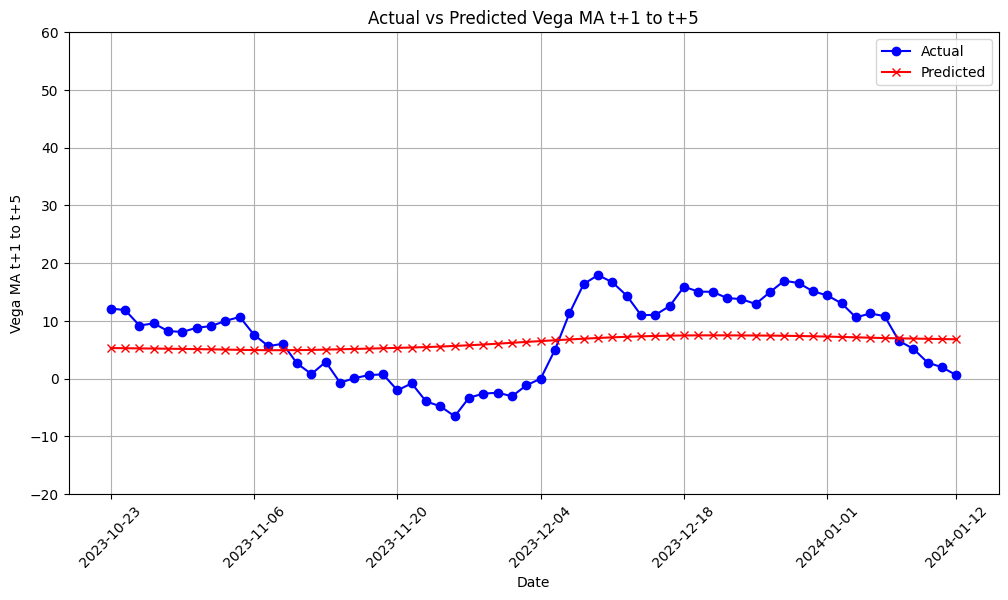

In [ ]:
# Prepare the data
df = loaded_df
n_features = 3  # 'Swap Rate', 'Implied Normal Volatility', 'Vega'
n_steps = 60

# Impute NaN values with the mean of the column
imputer = SimpleImputer(strategy='mean')
df[['Swap Rate', 'Implied Normal Volatility', 'Vega']] = imputer.fit_transform(df[['Swap Rate', 'Implied Normal Volatility', 'Vega']])

# Standardize the features
scaler = StandardScaler()
features = scaler.fit_transform(df[['Swap Rate', 'Implied Normal Volatility', 'Vega']])

# Function to create sequences
def create_sequences(features, target, n_steps):
    X, y = [], []
    for i in range(n_steps, len(features)):
        X.append(features[i-n_steps:i, :])
        y.append(target[i])
    return np.array(X), np.array(y)

# Create sequences for the entire dataset
X, y = create_sequences(features, df['Vega MA t+1 to t+5'].values.astype(float), n_steps)

# Filter out sequences where the target value is NaN
valid_indices = ~pd.isna(y)
X = X[valid_indices]
y = y[valid_indices]  # Keep y as float for regression

# Split the data into training and testing
X_train, X_test = X[:-60], X[-60:]
y_train, y_test = y[:-60], y[-60:]

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))  # Single output for regression

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

# Load the model weights
model.load_weights(os.path.join(weight_dir_path, 'best_lstm_prediction_model_n_steps_60.h5'))

# Make predictions
y_pred = model.predict(X_test)

# Print y_pred
print(f"y_pred: {y_pred}")

# Calculate Mean Squared Error and Mean Absolute Error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

# Plot real vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(df['Date'][-len(y_test):], y_test, label='Actual', color='blue', marker='o')
plt.plot(df['Date'][-len(y_pred):], y_pred, label='Predicted', color='red', marker='x')

# Customize x-ticks to show date for every 10 entries and the last date
xticks = list(range(0, len(y_test), 10)) + [len(y_test) - 1]
xtick_labels = df['Date'].values[-len(y_test):][xticks]
plt.xticks(xticks, xtick_labels, rotation=45)

plt.xlabel('Date')
plt.ylabel('Vega MA t+1 to t+5')
plt.title('Actual vs Predicted Vega MA t+1 to t+5')
plt.legend()
plt.ylim(-20, 60)
# plt.axvline(x=xticks[-61], color='grey', linestyle='--')  # Vertical line at the last 60th date
plt.grid(True)
plt.show()

# LSTM - Classification - n_steps = 20 (Ignore)

In [ ]:
# Prepare the data
df = loaded_df
n_features = 3  # 'Swap Rate', 'Implied Normal Volatility', 'Vega'
n_steps = 20

# Hyperparameters
epochs=150
batch_size=32

# Impute NaN values with the mean of the column
imputer = SimpleImputer(strategy='mean')
df[['Swap Rate', 'Implied Normal Volatility', 'Vega']] = imputer.fit_transform(df[['Swap Rate', 'Implied Normal Volatility', 'Vega']])

# Standardize the features
scaler = StandardScaler()
features = scaler.fit_transform(df[['Swap Rate', 'Implied Normal Volatility', 'Vega']])

# Function to create sequences
def create_sequences(features, target, n_steps):
    X, y = [], []
    for i in range(n_steps, len(features)):
        X.append(features[i-n_steps:i, :])
        y.append(target[i])
    return np.array(X), np.array(y)

# Create sequences for the entire dataset
X, y = create_sequences(features, df['Vega MA t+1 to t+5 Cluster'].values.astype(float), n_steps)

# Filter out sequences where the target value is NaN
valid_indices = ~pd.isna(y)
X = X[valid_indices]
y = y[valid_indices].astype(int)  # Ensure y is integer type

# Adjust y to be 0, 1, 2 for the model training
y_adjusted = y - 1

# Convert targets to categorical
y_categorical = pd.get_dummies(y_adjusted).values

# Split the data into training and testing
X_train, X_test = X[:-60], X[-60:]
y_train, y_test = y_categorical[:-60], y_categorical[-60:]

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define checkpoint to save the best model
checkpoint_filepath = os.path.join(weight_dir_path, 'best_lstm_classification_model_n_steps_20.h5')
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_accuracy', mode='max')

# Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[checkpoint])

# Save the final model weights
model.save_weights(os.path.join(weight_dir_path, 'lstm_classification_final_weights_n_steps_20.h5'))

# Print the training and testing loss and accuracy
training_loss = history.history['loss']
testing_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
testing_accuracy = history.history['val_accuracy']

print("Training Loss:", training_loss)
print("Testing Loss:", testing_loss)
print("Training Accuracy:", training_accuracy)
print("Testing Accuracy:", testing_accuracy)

Epoch 1/150
9/9 [==============================] - ETA: 0s - loss: 1.0306 - accuracy: 0.5775

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 5s 182ms/step - loss: 1.0306 - accuracy: 0.5775 - val_loss: 1.0808 - val_accuracy: 0.0500
Epoch 2/150
9/9 [==============================] - 0s 43ms/step - loss: 0.8320 - accuracy: 0.8627 - val_loss: 1.5040 - val_accuracy: 0.0500
Epoch 3/150
9/9 [==============================] - 0s 25ms/step - loss: 0.5402 - accuracy: 0.8662 - val_loss: 1.6670 - val_accuracy: 0.0500
Epoch 4/150
9/9 [==============================] - 0s 25ms/step - loss: 0.4556 - accuracy: 0.8732 - val_loss: 1.8606 - val_accuracy: 0.0500
Epoch 5/150
9/9 [==============================] - 0s 26ms/step - loss: 0.4189 - accuracy: 0.8838 - val_loss: 1.5297 - val_accuracy: 0.0500
Epoch 6/150
9/9 [==============================] - 0s 27ms/step - loss: 0.3955 - accuracy: 0.8768 - val_loss: 1.8153 - val_accuracy: 0.0500
Epoch 7/150
9/9 [==============================] - 0s 25ms/step - loss: 0.3886 - accuracy: 0.8803 - val_loss: 1.9124 - val_accuracy: 0.0500
Epoch 8/150
9/9 [==============

2/2 [==============================] - 1s 14ms/step


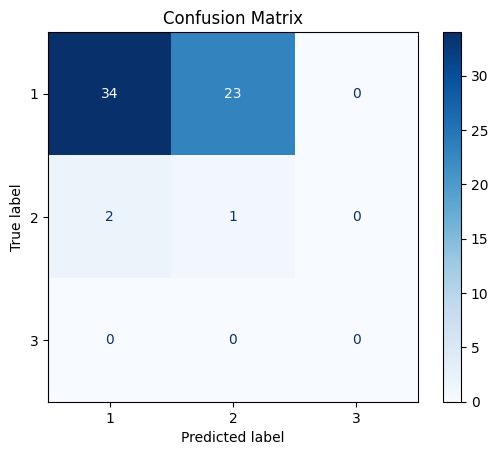

In [ ]:
# Prepare the data
df = loaded_df
n_features = 3  # 'Swap Rate', 'Implied Normal Volatility', 'Vega'
n_steps = 20

# Impute NaN values with the mean of the column
imputer = SimpleImputer(strategy='mean')
df[['Swap Rate', 'Implied Normal Volatility', 'Vega']] = imputer.fit_transform(df[['Swap Rate', 'Implied Normal Volatility', 'Vega']])

# Standardize the features
scaler = StandardScaler()
features = scaler.fit_transform(df[['Swap Rate', 'Implied Normal Volatility', 'Vega']])

# Function to create sequences
def create_sequences(features, target, n_steps):
    X, y = [], []
    for i in range(n_steps, len(features)):
        X.append(features[i-n_steps:i, :])
        y.append(target[i])
    return np.array(X), np.array(y)

# Create sequences for the entire dataset
X, y = create_sequences(features, df['Vega MA t+1 to t+5 Cluster'].values.astype(float), n_steps)

# Filter out sequences where the target value is NaN
valid_indices = ~pd.isna(y)
X = X[valid_indices]
y = y[valid_indices].astype(int)  # Ensure y is integer type

# Adjust y to be 0, 1, 2 for the model training
y_adjusted = y - 1

# Convert targets to categorical
y_categorical = pd.get_dummies(y_adjusted).values

# Split the data into training and testing
X_train, X_test = X[:-60], X[-60:]
y_train, y_test = y_categorical[:-60], y_categorical[-60:]

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Load the model weights
model.load_weights(os.path.join(weight_dir_path, 'best_lstm_classification_model_n_steps_20.h5'))

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Adjust the classes back to 1, 2, 3
y_pred_classes_adjusted = y_pred_classes + 1
y_test_classes_adjusted = y_test_classes + 1

# Compute and display the confusion matrix
cm = confusion_matrix(y_test_classes_adjusted, y_pred_classes_adjusted, labels=[1, 2, 3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# LSTM - Prediction - n_steps = 20 (Ignore)

In [ ]:
# Prepare the data
df = loaded_df
n_features = 3  # 'Swap Rate', 'Implied Normal Volatility', 'Vega'
n_steps = 20

# Hyperparameters
epochs = 150
batch_size = 32

# Impute NaN values with the mean of the column
imputer = SimpleImputer(strategy='mean')
df[['Swap Rate', 'Implied Normal Volatility', 'Vega']] = imputer.fit_transform(df[['Swap Rate', 'Implied Normal Volatility', 'Vega']])

# Standardize the features
scaler = StandardScaler()
features = scaler.fit_transform(df[['Swap Rate', 'Implied Normal Volatility', 'Vega']])

# Function to create sequences
def create_sequences(features, target, n_steps):
    X, y = [], []
    for i in range(n_steps, len(features)):
        X.append(features[i-n_steps:i, :])
        y.append(target[i])
    return np.array(X), np.array(y)

# Create sequences for the entire dataset
X, y = create_sequences(features, df['Vega MA t+1 to t+5'].values.astype(float), n_steps)

# Filter out sequences where the target value is NaN
valid_indices = ~pd.isna(y)
X = X[valid_indices]
y = y[valid_indices]  # Keep y as float for regression

# Split the data into training and testing
X_train, X_test = X[:-60], X[-60:]
y_train, y_test = y[:-60], y[-60:]

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))  # Single output for regression

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

# Define checkpoint to save the best model based on validation loss
checkpoint_filepath = os.path.join(weight_dir_path, 'best_lstm_prediction_model_n_steps_20.h5')
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_loss', mode='min')

# Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[checkpoint])

# Save the final model weights
model.save_weights(os.path.join(weight_dir_path, 'lstm_prediction_final_weights_n_steps_20.h5'))

# Print the training and testing loss and accuracy
training_loss = history.history['loss']
testing_loss = history.history['val_loss']
training_mse = history.history['mean_squared_error']
testing_mse = history.history['val_mean_squared_error']

print("Training Loss:", training_loss)
print("Testing Loss:", testing_loss)
print("Training MSE:", training_mse)
print("Testing MSE:", testing_mse)

Epoch 1/150
7/9 [======================>.......] - ETA: 0s - loss: 2363333.2500 - mean_squared_error: 2363333.2500

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 5s 129ms/step - loss: 2329818.0000 - mean_squared_error: 2329818.0000 - val_loss: 97.0404 - val_mean_squared_error: 97.0404
Epoch 2/150
9/9 [==============================] - 0s 30ms/step - loss: 2329758.0000 - mean_squared_error: 2329758.0000 - val_loss: 91.2631 - val_mean_squared_error: 91.2631
Epoch 3/150
9/9 [==============================] - 0s 31ms/step - loss: 2329710.0000 - mean_squared_error: 2329710.0000 - val_loss: 58.7609 - val_mean_squared_error: 58.7609
Epoch 4/150
9/9 [==============================] - 0s 26ms/step - loss: 2329460.7500 - mean_squared_error: 2329460.7500 - val_loss: 261.6812 - val_mean_squared_error: 261.6812
Epoch 5/150
9/9 [==============================] - 0s 25ms/step - loss: 2327469.5000 - mean_squared_error: 2327469.5000 - val_loss: 444.5216 - val_mean_squared_error: 444.5216
Epoch 6/150
9/9 [==============================] - 0s 24ms/step - loss: 2312479.5000 - mean_squared_error: 2312479.5000 - val_loss: 883.8

2/2 [==============================] - 0s 12ms/step
y_pred: [[3.0019753]
 [3.0854068]
 [3.2112877]
 [3.3896403]
 [3.5756946]
 [3.7942789]
 [4.033388 ]
 [4.2992706]
 [4.5787253]
 [4.892102 ]
 [5.2472587]
 [5.6280446]
 [6.0088234]
 [6.4250665]
 [6.874215 ]
 [7.293099 ]
 [7.70356  ]
 [8.126839 ]
 [8.5475855]
 [8.822134 ]
 [8.666535 ]
 [8.475638 ]
 [8.186581 ]
 [7.887034 ]
 [7.5559955]
 [7.2539177]
 [6.986362 ]
 [6.7503333]
 [6.490372 ]
 [6.287978 ]
 [6.1160755]
 [5.951919 ]
 [5.829795 ]
 [5.7813   ]
 [5.770479 ]
 [5.785973 ]
 [5.82645  ]
 [5.9127116]
 [6.019282 ]
 [6.0964785]
 [6.1812763]
 [6.248945 ]
 [6.310861 ]
 [6.290549 ]
 [6.258058 ]
 [6.212255 ]
 [6.1693907]
 [6.1081104]
 [6.0404196]
 [5.9861555]
 [5.922513 ]
 [5.8787374]
 [5.844561 ]
 [5.7901163]
 [5.724506 ]
 [5.68806  ]
 [5.6446743]
 [5.6317677]
 [5.615616 ]
 [5.571615 ]]
Mean Squared Error: 58.7609
Mean Absolute Error: 6.9621


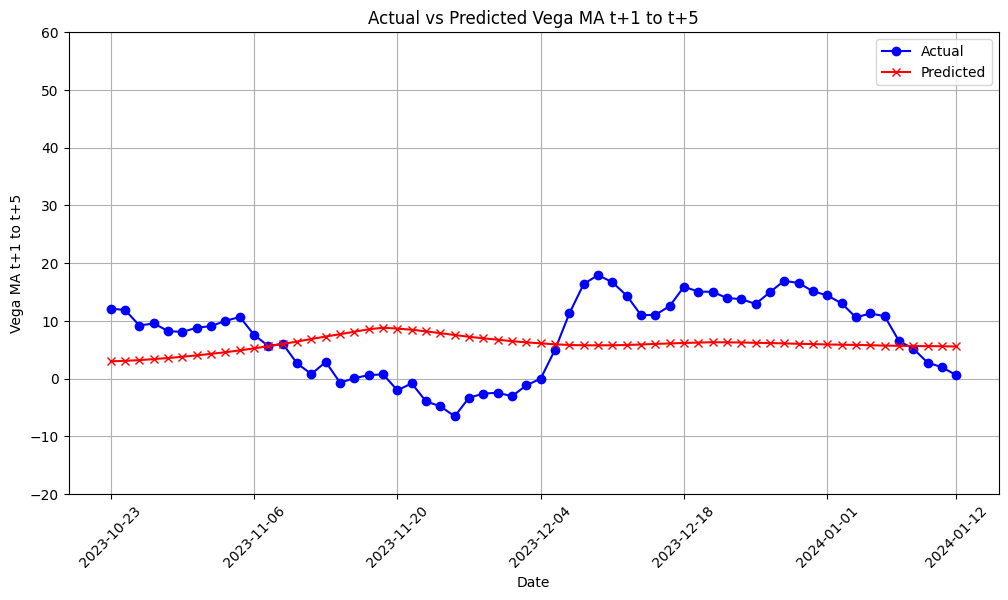

In [ ]:
# Prepare the data
df = loaded_df
n_features = 3  # 'Swap Rate', 'Implied Normal Volatility', 'Vega'
n_steps = 20

# Impute NaN values with the mean of the column
imputer = SimpleImputer(strategy='mean')
df[['Swap Rate', 'Implied Normal Volatility', 'Vega']] = imputer.fit_transform(df[['Swap Rate', 'Implied Normal Volatility', 'Vega']])

# Standardize the features
scaler = StandardScaler()
features = scaler.fit_transform(df[['Swap Rate', 'Implied Normal Volatility', 'Vega']])

# Function to create sequences
def create_sequences(features, target, n_steps):
    X, y = [], []
    for i in range(n_steps, len(features)):
        X.append(features[i-n_steps:i, :])
        y.append(target[i])
    return np.array(X), np.array(y)

# Create sequences for the entire dataset
X, y = create_sequences(features, df['Vega MA t+1 to t+5'].values.astype(float), n_steps)

# Filter out sequences where the target value is NaN
valid_indices = ~pd.isna(y)
X = X[valid_indices]
y = y[valid_indices]  # Keep y as float for regression

# Split the data into training and testing
X_train, X_test = X[:-60], X[-60:]
y_train, y_test = y[:-60], y[-60:]

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))  # Single output for regression

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

# Load the model weights
model.load_weights(os.path.join(weight_dir_path, 'best_lstm_prediction_model_n_steps_20.h5'))

# Make predictions
y_pred = model.predict(X_test)

# Print y_pred
print(f"y_pred: {y_pred}")

# Calculate Mean Squared Error and Mean Absolute Error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

# Plot real vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(df['Date'][-len(y_test):], y_test, label='Actual', color='blue', marker='o')
plt.plot(df['Date'][-len(y_pred):], y_pred, label='Predicted', color='red', marker='x')

# Customize x-ticks to show date for every 10 entries and the last date
xticks = list(range(0, len(y_test), 10)) + [len(y_test) - 1]
xtick_labels = df['Date'].values[-len(y_test):][xticks]
plt.xticks(xticks, xtick_labels, rotation=45)

plt.xlabel('Date')
plt.ylabel('Vega MA t+1 to t+5')
plt.title('Actual vs Predicted Vega MA t+1 to t+5')
plt.legend()
plt.ylim(-20, 60)
# plt.axvline(x=xticks[-61], color='grey', linestyle='--')  # Vertical line at the last 60th date
plt.grid(True)
plt.show()

# Compare XGBoost VS LSTM

In [ ]:
print(y_test)

[ 1.21487280e+01  1.18736842e+01  9.20018259e+00  9.57201811e+00
  8.22976060e+00  8.10196081e+00  8.81668765e+00  9.10763227e+00
  1.00079720e+01  1.06870589e+01  7.59036994e+00  5.63196229e+00
  6.04491707e+00  2.63065405e+00  8.03671410e-01  2.90320751e+00
 -6.98655604e-01  8.80262040e-02  6.17379352e-01  7.44017490e-01
 -2.00906606e+00 -8.20649156e-01 -3.93904127e+00 -4.78876750e+00
 -6.51733958e+00 -3.29117501e+00 -2.59508298e+00 -2.43084676e+00
 -3.04609873e+00 -1.14762078e+00 -4.86442000e-04  5.02808025e+00
  1.12859825e+01  1.63881767e+01  1.79364181e+01  1.66987478e+01
  1.43900585e+01  1.10018947e+01  1.10457121e+01  1.25660480e+01
  1.59146726e+01  1.50803642e+01  1.50352169e+01  1.39661282e+01
  1.37755526e+01  1.29337832e+01  1.49890002e+01  1.69585970e+01
  1.65548380e+01  1.51294174e+01  1.44168835e+01  1.30387767e+01
  1.06101298e+01  1.12895965e+01  1.08261454e+01  6.53455452e+00
  5.18505889e+00  2.79025310e+00  1.97854518e+00  6.13484282e-01]


XGBoost Mean Absolute Error: 9.267170253333335
XGBoost Mean Squared Error: 124.69028229733836
LSTM Mean Absolute Error: 5.787089545999999
LSTM Mean Squared Error: 40.68057828984047


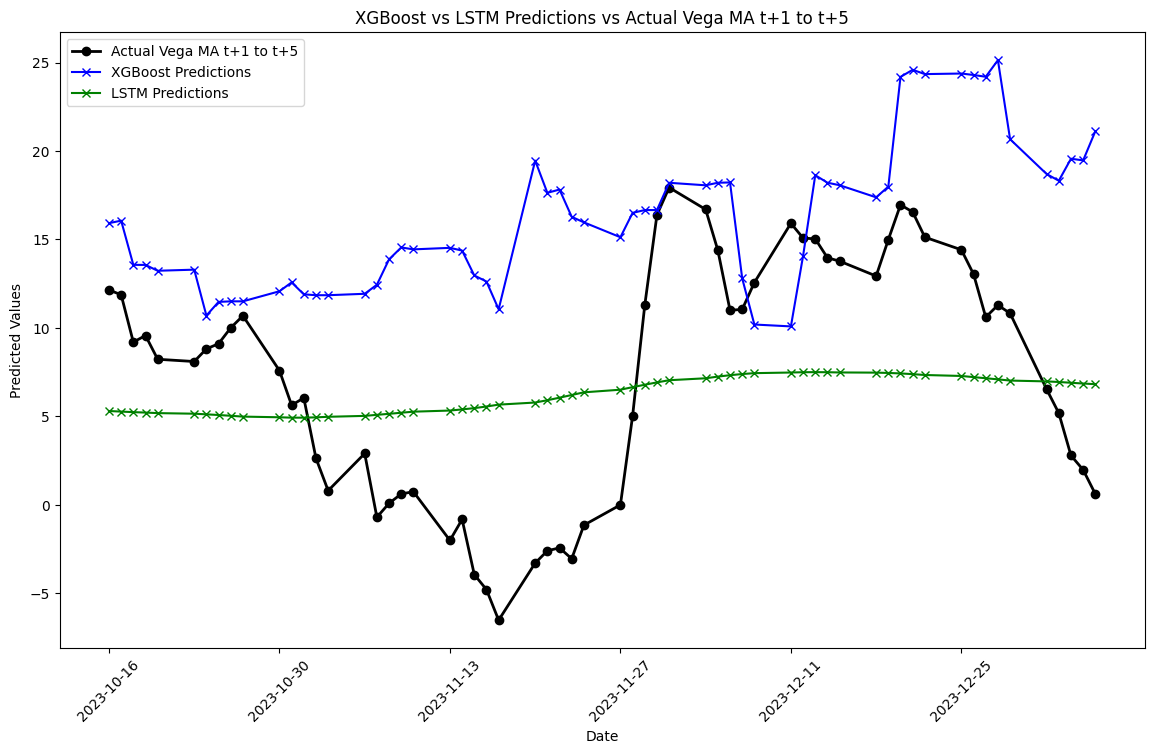

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Dates for the X-axis
dates = [
    "2023-10-16", "2023-10-17", "2023-10-18", "2023-10-19", "2023-10-20",
    "2023-10-23", "2023-10-24", "2023-10-25", "2023-10-26", "2023-10-27",
    "2023-10-30", "2023-10-31", "2023-11-01", "2023-11-02", "2023-11-03",
    "2023-11-06", "2023-11-07", "2023-11-08", "2023-11-09", "2023-11-10",
    "2023-11-13", "2023-11-14", "2023-11-15", "2023-11-16", "2023-11-17",
    "2023-11-20", "2023-11-21", "2023-11-22", "2023-11-23", "2023-11-24",
    "2023-11-27", "2023-11-28", "2023-11-29", "2023-11-30", "2023-12-01",
    "2023-12-04", "2023-12-05", "2023-12-06", "2023-12-07", "2023-12-08",
    "2023-12-11", "2023-12-12", "2023-12-13", "2023-12-14", "2023-12-15",
    "2023-12-18", "2023-12-19", "2023-12-20", "2023-12-21", "2023-12-22",
    "2023-12-25", "2023-12-26", "2023-12-27", "2023-12-28", "2023-12-29",
    "2024-01-01", "2024-01-02", "2024-01-03", "2024-01-04", "2024-01-05"
]

# Convert dates to datetime objects
dates = pd.to_datetime(dates)

# Actual Y values
actual_y = [
    12.148728, 11.8736842, 9.20018259, 9.57201811, 8.2297606, 8.10196081, 8.81668765,
    9.10763227, 10.007972, 10.6870589, 7.59036994, 5.63196229, 6.04491707, 2.63065405,
    0.80367141, 2.90320751, -0.6986556, 0.088026204, 0.617379352, 0.74401749,
    -2.00906606, -0.820649156, -3.93904127, -4.7887675, -6.51733958, -3.29117501,
    -2.59508298, -2.43084676, -3.04609873, -1.14762078, -0.000486442, 5.02808025,
    11.2859825, 16.3881767, 17.9364181, 16.6987478, 14.3900585, 11.0018947, 11.0457121,
    12.566048, 15.9146726, 15.0803642, 15.0352169, 13.9661282, 13.7755526, 12.9337832,
    14.9890002, 16.958597, 16.554838, 15.1294174, 14.4168835, 13.0387767, 10.6101298,
    11.2895965, 10.8261454, 6.53455452, 5.18505889, 2.7902531, 1.97854518, 0.613484282
]

# XGBoost results
xgboost_results = [
    15.923105, 16.064638, 13.565365, 13.562151, 13.232129, 13.294435, 10.699743,
    11.47287, 11.503215, 11.504204, 12.073047, 12.574176, 11.899978, 11.8504,
    11.8504, 11.930425, 12.439631, 13.877044, 14.549676, 14.441268, 14.527125,
    14.372716, 12.966536, 12.62319, 11.055263, 19.458208, 17.637243, 17.822105,
    16.280773, 15.968704, 15.126815, 16.504139, 16.663214, 16.663214, 18.204557,
    18.062513, 18.20665, 18.224548, 12.804159, 10.193473, 10.086835, 14.072887,
    18.632637, 18.209759, 18.066868, 17.382988, 17.986826, 24.189402, 24.590622,
    24.347736, 24.380178, 24.298157, 24.197235, 25.135536, 20.666779, 18.699274,
    18.320623, 19.564394, 19.472021, 21.117811
]

# LSTM results
lstm_results = [
    5.3054667, 5.271327, 5.24186, 5.216582, 5.1857076, 5.1523438, 5.1168694, 5.0788875,
    5.0353913, 4.988697, 4.950624, 4.928872, 4.9296565, 4.9463162, 4.978225, 5.0291066,
    5.08865, 5.1457286, 5.207164, 5.2673707, 5.3307695, 5.395331, 5.4685974, 5.559135,
    5.665237, 5.7840967, 5.914922, 6.0582128, 6.2096562, 6.3610435, 6.5088186, 6.653611,
    6.789149, 6.922458, 7.044743, 7.155146, 7.2492604, 7.329547, 7.3939276, 7.4448876,
    7.480328, 7.497507, 7.50167, 7.4968467, 7.4840097, 7.4744005, 7.455917, 7.4289865,
    7.389196, 7.3403974, 7.285682, 7.2205367, 7.1577954, 7.093846, 7.025191, 6.9781065,
    6.945091, 6.901743, 6.8580627, 6.8211184
]

# Calculate errors
mae_xgboost = mean_absolute_error(actual_y, xgboost_results)
mse_xgboost = mean_squared_error(actual_y, xgboost_results)

mae_lstm = mean_absolute_error(actual_y, lstm_results)
mse_lstm = mean_squared_error(actual_y, lstm_results)

print(f"XGBoost Mean Absolute Error: {mae_xgboost}")
print(f"XGBoost Mean Squared Error: {mse_xgboost}")
print(f"LSTM Mean Absolute Error: {mae_lstm}")
print(f"LSTM Mean Squared Error: {mse_lstm}")

# Plotting the results
plt.figure(figsize=(14, 8))

plt.plot(dates, actual_y, label='Actual Vega MA t+1 to t+5', color='black', linestyle='-', linewidth=2, marker='o')
plt.plot(dates, xgboost_results, label='XGBoost Predictions', color='blue', marker='x')
plt.plot(dates, lstm_results, label='LSTM Predictions', color='green', marker='x')

plt.xlabel('Date')
plt.ylabel('Predicted Values')
plt.title('XGBoost vs LSTM Predictions vs Actual Vega MA t+1 to t+5')
plt.xticks(dates[::10], rotation=45)
# plt.axvline(x=dates[-60], color='red', linestyle='--', label='Train/Test Split')
plt.legend()
